# Assessment - Tey Huimin

## Load Library

In [1]:
import pandas as pd
import pytesseract
import numpy as np
import re
import os
import cv2
import shutil
from matplotlib import pyplot as plt
from pdf2image import convert_from_path
from datetime import date
import itertools
from datetime import date, timedelta  
from dateutil.relativedelta import relativedelta
import oss2
import os 
from matplotlib.patches import Rectangle
from google.cloud import vision
import io

# %load_ext autotime
%reload_ext autotime

# Load Google service account json file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.getcwd()+'/g_keys.json'

time: 342 µs (started: 2024-05-06 21:12:54 +08:00)


## Step 1 : Segmenting the page by lines

Use OpenCV to find lines between sections, and use the coordinates of the lines to break the image into segments

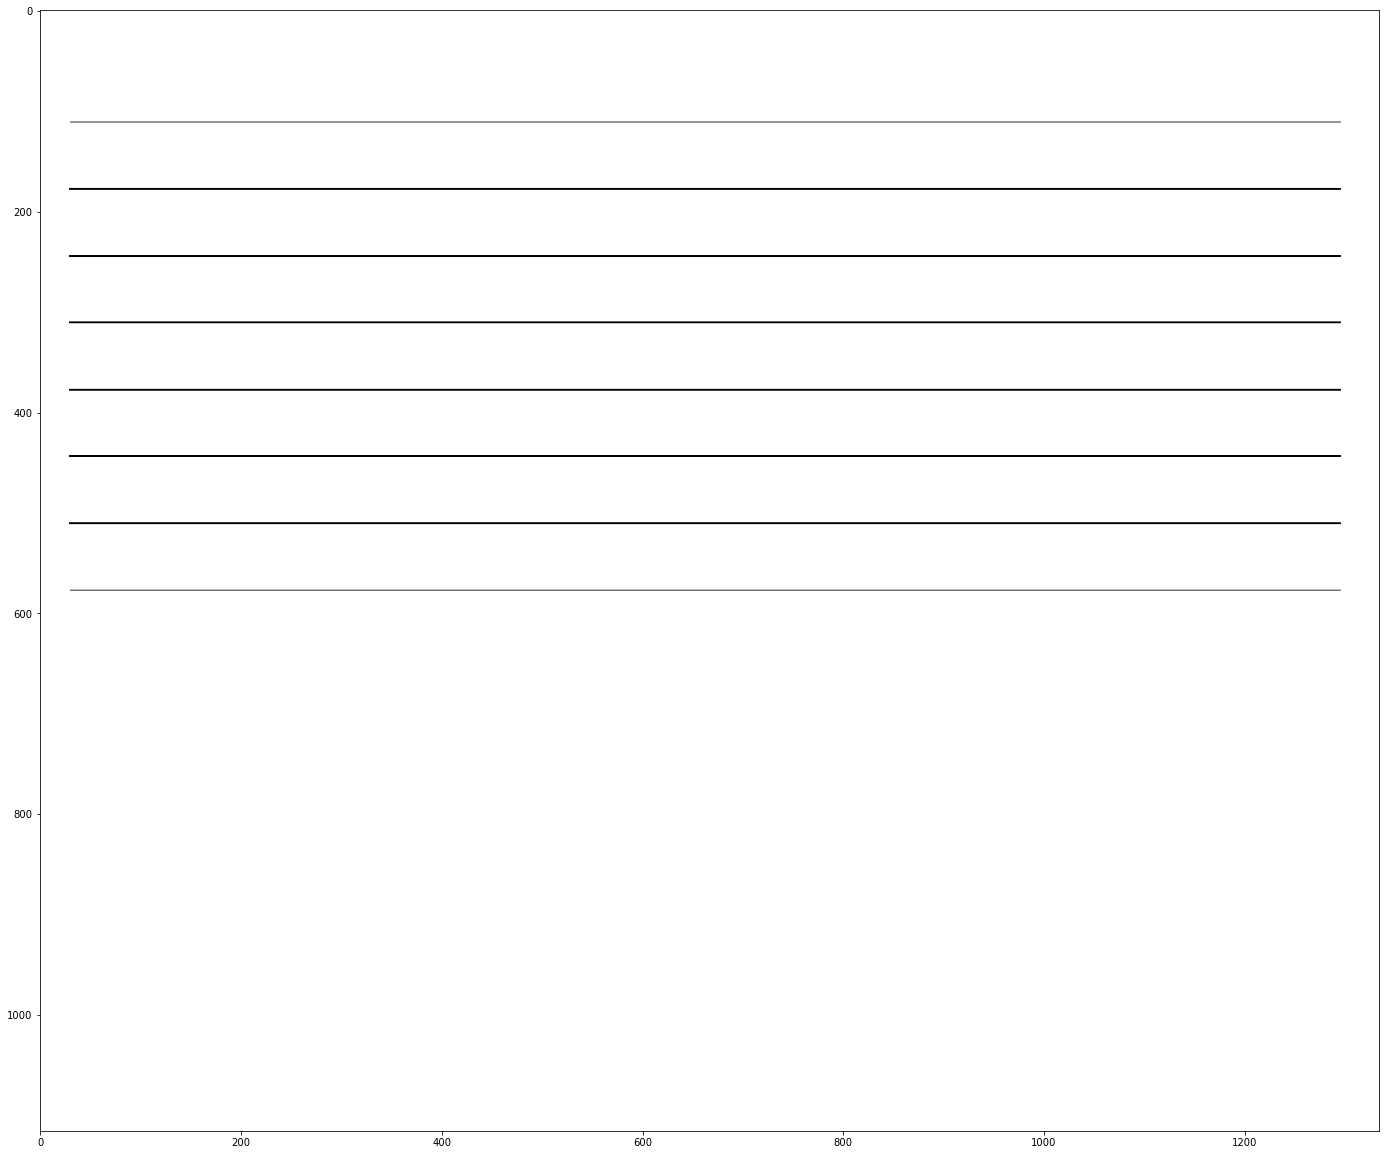

time: 697 ms (started: 2024-05-06 21:12:54 +08:00)


In [2]:
image_path = 'img.png' 

def findHorizontalLines(img):
    img = cv2.imread(img) 
    
    #convert image to greyscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # set threshold to remove background noise
    thresh = cv2.threshold(gray,30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    
    # define rectangle structure (line) to look for: width 100, hight 1. This is a 
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (200,1))
    
    # Find horizontal lines
    lineLocations = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    
    return lineLocations

lineLocations = findHorizontalLines(image_path)
plt.figure(figsize=(24,24))
plt.imshow(lineLocations, cmap='Greys')

In [3]:
df_lineLocations = pd.DataFrame(lineLocations.sum(axis=1)).reset_index()
df_lineLocations.columns = ['rowLoc', 'LineLength']
df_lineLocations[df_lineLocations['LineLength'] > 0]

,rowLoc,LineLength
111,111,322575
177,177,322830
178,178,322830
244,244,322830
245,245,322830
310,310,322830
311,311,322830
377,377,322830
378,378,322830
443,443,322830


time: 9.99 ms (started: 2024-05-06 21:12:55 +08:00)


In [4]:
df_lineLocations['line'] = 0
df_lineLocations['line'][df_lineLocations['LineLength'] > 100] = 1

df_lineLocations['cumSum'] = df_lineLocations['line'].cumsum()
df_lineLocations.head()

/var/folders/34/8y5wtrvx2l3gm5t_10cfxprc0000gp/T/ipykernel_11109/3012487649.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lineLocations['line'][df_lineLocations['LineLength'] > 100] = 1


,rowLoc,LineLength,line,cumSum
0,0,0,0,0
1,1,0,0,0
2,2,0,0,0
3,3,0,0,0
4,4,0,0,0


time: 7.25 ms (started: 2024-05-06 21:12:55 +08:00)


In [16]:
# Filter the DataFrame
filtered_df = df_lineLocations[df_lineLocations['line'] == 0]

# Group by cumSum and perform aggregations
grouped_df = filtered_df.groupby('cumSum').agg(
    SegmentStart=('rowLoc', 'min'),
    Height=('rowLoc', lambda x: x.max() - x.min())
)

# Add SegmentOrder column using row_number()
grouped_df['SegmentOrder'] = range(1, len(grouped_df) + 1)

# Reorder columns as per the original SQL query
df_SegmentLocations = grouped_df[['SegmentOrder', 'SegmentStart', 'Height']].reset_index()
df_SegmentLocations = df_SegmentLocations.drop('cumSum', axis=1)
df_SegmentLocations

,SegmentOrder,SegmentStart,Height
0,1,0,110
1,2,112,64
2,3,179,64
3,4,246,63
4,5,312,64
5,6,379,63
6,7,445,64
7,8,512,64
8,9,578,537


time: 14.9 ms (started: 2024-05-06 21:20:38 +08:00)


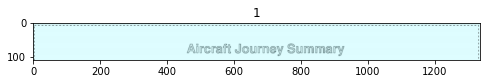

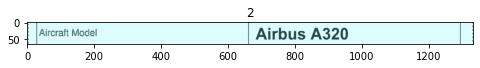

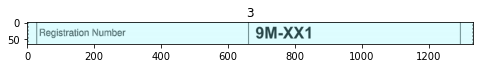

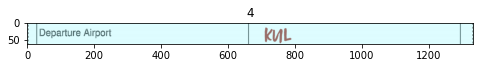

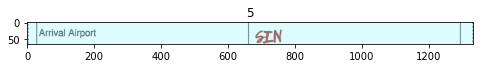

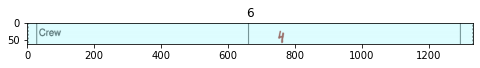

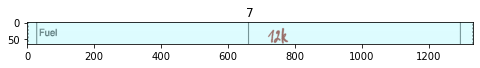

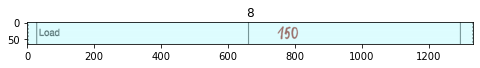

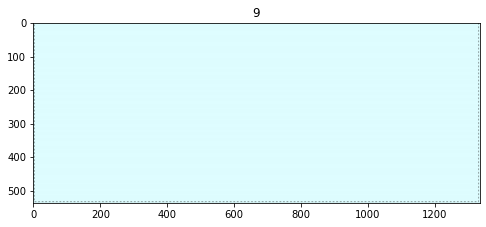

time: 758 ms (started: 2024-05-06 21:20:56 +08:00)


In [17]:
def pageSegmentation1(img, w, df_SegmentLocations):
    img = cv2.imread(img) 
    im2 = img.copy()
    segments = []

    for i in range(len(df_SegmentLocations)):
        y = df_SegmentLocations['SegmentStart'][i]
        h = df_SegmentLocations['Height'][i]

        cropped = im2[y:y + h, 0:w] 
        segments.append(cropped)
        plt.figure(figsize=(8,8))
        plt.imshow(cropped)
        plt.title(str(i+1))        

    return segments

img = image_path
w = lineLocations.shape[1]
segments = pageSegmentation1(img, w, df_SegmentLocations)

## Step 2 : Extracting the text by segments

Using Google Cloud Vision API for the image to text extraction as it can accommodate handwritten text extraction better and pytesseract.

In [19]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.getcwd()+'/g_keys.json'

time: 748 µs (started: 2024-05-06 21:25:13 +08:00)


In [18]:
def CloudVisionTextExtractor(handwritings):
    # convert image from numpy to bytes for submittion to Google Cloud Vision
    _, encoded_image = cv2.imencode('.png', handwritings)
    content = encoded_image.tobytes()
    image = vision.Image(content=content)
    
    # feed handwriting image segment to the Google Cloud Vision API
    client = vision.ImageAnnotatorClient()
    response = client.document_text_detection(image=image)
    
    return response

def getTextFromVisionResponse(response):
    texts = []
    for page in response.full_text_annotation.pages:
        for i, block in enumerate(page.blocks):  
            for paragraph in block.paragraphs:       
                for word in paragraph.words:
                    word_text = ''.join([symbol.text for symbol in word.symbols])
                    texts.append(word_text)

    return ' '.join(texts)

time: 1.49 ms (started: 2024-05-06 21:25:11 +08:00)


## Step 3 : Extract the value that comes after specified title

In [54]:
image_path = 'img.png'  

# Load the image
img = cv2.imread(image_path)

# Convert to grayscale
image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Define substring labels
substrings = {
    "Aircraft Model": "Aircraft Model",
    "Registration Number": "Registration Number",
    "Departure Airport": "Departure Airport",
    "Arrival Airport": "Arrival Airport",
    "Crew": "Crew",
    "Fuel": "Fuel",
    "Load": "Load"
}

# Loop through the coordinates
columns = []
values = []

for i in range(1, len(df_SegmentLocations) - 1):
    y = df_SegmentLocations['SegmentStart'][i]
    h = df_SegmentLocations['Height'][i]
    
    w = lineLocations.shape[1]

    try:
        cropped_image = image[y:y + h, 0:w] 
        response = CloudVisionTextExtractor(cropped_image)
        result = getTextFromVisionResponse(response)
        
        # Remove unwanted text
        cleaned_text = result.replace("☐", "")
        
        # Loop through substrings to find matching substring label
        for substring_label, substring in substrings.items():
            if substring in cleaned_text:
                # Extract text after the substring
                text = cleaned_text.split(substring)[-1].strip()
                columns.append(substring_label)
                values.append(text)
                break  # Break loop once substring is found

    except IndexError:
        print(f"Empty text from Image - skipping")

df = pd.DataFrame([values], columns=columns)
df

,Aircraft Model,Registration Number,Departure Airport,Arrival Airport,Crew,Fuel,Load
0,Airbus A320,9M - XX1,KUL,SIN,4,12k,150


time: 2.11 s (started: 2024-05-06 21:48:15 +08:00)


In [ ]:
# proceed to push dataframe to preferred data warehouse - example used for RedShift
df.to_sql(
            name = 'aircraft_journey_summary',
            con = redshift_engine,
            schema = 'airasia',
            if_exists = 'append',
            index = False,
            method = 'multi',
            chunksize = 5000
            )

# Appendix

## 1) Google Cloud Vision API

In [34]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.getcwd()+'/g_keys.json'

time: 1.54 ms (started: 2024-05-06 21:40:34 +08:00)


In [35]:
GOOGLE_APPLICATION_CREDENTIALS = os.environ.get('GOOGLE_APPLICATION_CREDENTIALS')
GOOGLE_APPLICATION_CREDENTIALS

'/Users/ad1049-ade-mb-1/Huimin_Local/03_Exercises/01_Machine Learning/04_AirAsia/g_keys.json'

time: 2.31 ms (started: 2024-05-06 21:40:35 +08:00)


In [36]:

def CloudVisionTextExtractor(handwritings):
    # convert image from numpy to bytes for submittion to Google Cloud Vision
    _, encoded_image = cv2.imencode('.png', handwritings)
    content = encoded_image.tobytes()
    image = vision.Image(content=content)
    
    # feed handwriting image segment to the Google Cloud Vision API
    client = vision.ImageAnnotatorClient()
    response = client.document_text_detection(image=image)
    
    return response

def getTextFromVisionResponse(response):
    texts = []
    for page in response.full_text_annotation.pages:
        for i, block in enumerate(page.blocks):  
            for paragraph in block.paragraphs:       
                for word in paragraph.words:
                    word_text = ''.join([symbol.text for symbol in word.symbols])
                    texts.append(word_text)

    return ' '.join(texts)

time: 1.82 ms (started: 2024-05-06 21:40:36 +08:00)


## 1.1) Function for Image to Text Extraction

In [37]:
def CloudVisionTextExtractor(handwritings):
    # convert image from numpy to bytes for submittion to Google Cloud Vision
    _, encoded_image = cv2.imencode('.png', handwritings)
    content = encoded_image.tobytes()
    image = vision.Image(content=content)
    
    # feed handwriting image segment to the Google Cloud Vision API
    client = vision.ImageAnnotatorClient()
    response = client.document_text_detection(image=image)
    
    return response

def getTextFromVisionResponse(response):
    texts = []
    for page in response.full_text_annotation.pages:
        for i, block in enumerate(page.blocks):  
            for paragraph in block.paragraphs:       
                for word in paragraph.words:
                    word_text = ''.join([symbol.text for symbol in word.symbols])
                    texts.append(word_text)

    return ' '.join(texts)

time: 1.46 ms (started: 2024-05-06 21:40:39 +08:00)


'Aircraft Model Registration Number Departure Airport Arrival Airport Crew Fuel Load Aircraft Journey Summary Airbus A320 9M - XX1 KUL SIN 4 12k 150'

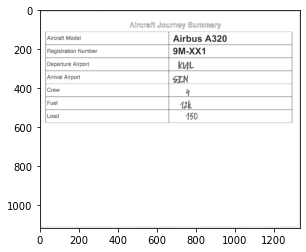

time: 747 ms (started: 2024-05-06 21:40:40 +08:00)


In [38]:
image_path = 'img.png'  

# Load the image
img = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

response = CloudVisionTextExtractor(img)
text = getTextFromVisionResponse(response)
text

In [39]:
# Create a Vision API client
client = vision.ImageAnnotatorClient()

# Read the image from file
with io.open('img.png', 'rb') as image_file:
    content = image_file.read()

# Construct an image instance
image = vision.Image(content=content)

# Perform text detection
response = client.document_text_detection(image=image)

time: 594 ms (started: 2024-05-06 21:40:43 +08:00)


## 1.2) Converting Img to Text - row wise

In [40]:
# List of tuples with coordinates and sizes
coordinates = [
    # (30, 40, 1200, 65), # Aircraft Journey Summary
    (30, 110, 1200, 65), # Registration Number
    (30, 180, 1200, 65), # Departure Airport
    (30,240,1200,65), # Arrival Airport
    (30,310,1200,65), # Crew
    (30,380,1200,65), # Fuel
    (30,440,1200,65), # Load
    (30,510,1200,65)
]

# Loop through the coordinates
columns = []
values = []

for (x1, y1, w1, h1) in coordinates:
    # Crop the image using the current coordinates
    cropped_image = gray[y1:y1+h1, x1:x1+w1]
    response = CloudVisionTextExtractor(cropped_image)
    result = getTextFromVisionResponse(response)
    text = result.rsplit(' ',1)
    columns.append(text[0])
    values.append(text[1])
    
df = pd.DataFrame([values], columns=columns)

time: 2.09 s (started: 2024-05-06 21:40:45 +08:00)


In [41]:
df

,Aircraft Model Airbus,Registration Number 9M -,Departure Airport,Arrival Airport,Crew,Fuel,Load
0,A320,XX1,KUL,SIN,4,12k,150


time: 10.2 ms (started: 2024-05-06 21:40:49 +08:00)


Conclusion Google Cloud Vision API:
- From the above results, we can see that Google Cloud Vision API has done a much better job in extracting texts from image files than Tesseract.

## 2) Tesseract (Not preferred for handwritten notes)

## 2.1) Extracting Text from Img

In [42]:
image_path = 'img.png'  

# Load the image
img = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Extract text using OCR
extract_data = pytesseract.image_to_string(gray, lang='eng')


# Define substring labels
substrings = {
    "Aircraft Journey Summary": "Aircraft Journey Summary",
    "Aircraft Model": "Aircraft Model",
    "Registration Number": "Registration Number",
    "Departure Airport": "Departure Airport",
    "Arrival Airport": "Arrival Airport",
    "Crew": "Crew",
    "Fuel": "Fuel",
    "Load": "Load"
}

# Extract text between substrings
data = {}
for key, value in substrings.items():
    match = re.search(rf"{value}\s*([\s\S]+?)(?={substrings[key + ' Next'] if key + ' Next' in substrings else '$'})", extract_data)
    if match:
        data[key] = match.group(1).strip()

# Remove unwanted values
cleaned_data = {key: value.split('\n', -1)[0] for key, value in data.items()}
print(cleaned_data)

{'Aircraft Model': 'Airbus A320', 'Registration Number': 'IM-XX1', 'Departure Airport': 'kw L', 'Arrival Airport': 'gIN', 'Crew': '4', 'Fuel': '1 lk', 'Load': '450'}
time: 3.07 s (started: 2024-05-06 21:41:07 +08:00)


## 2.2) Extracting text from page segment

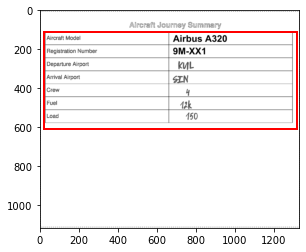

time: 281 ms (started: 2024-05-06 21:41:10 +08:00)


In [43]:
ref_img = cv2.imread('img.png')
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)
plt.imshow(ref_img)
ref = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)
ref = cv2.GaussianBlur(ref, (3,3), 0)
ref_roi = cv2.threshold(ref, 225, 255, cv2.THRESH_BINARY_INV)[1]
x,y,w,h = cv2.boundingRect(ref_roi)

ROI = ref[y:y+h, x:x+w]
plt.imshow(ROI, cmap='gray')

# Adjust ROI parameters

# Boxing
x1, y1, w1, h1 = (20,110,1300,500)
plt.gca().add_patch(Rectangle((x1,y1),w1,h1, edgecolor='red', facecolor='none', lw=2))


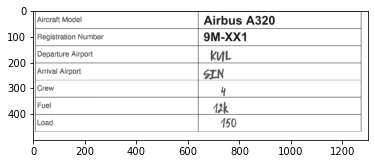

time: 607 ms (started: 2024-05-06 21:41:11 +08:00)


In [44]:
image_path = 'img.png'  

# Load the image
img = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
x1, y1, w1, h1 = (20,110,1300,500)
img = gray[y1:y1+h1, x1:x1+w1]
plt.imshow(img, cmap='gray')

# Extract text using OCR
extract_data = pytesseract.image_to_string(gray, lang='eng')



In [45]:

# Define substring labels
substrings = {
    "Aircraft Journey Summary": "Aircraft Journey Summary",
    "Aircraft Model": "Aircraft Model",
    "Registration Number": "Registration Number",
    "Departure Airport": "Departure Airport",
    "Arrival Airport": "Arrival Airport",
    "Crew": "Crew",
    "Fuel": "Fuel",
    "Load": "Load"
}

# Extract text between substrings
data = {}
for key, value in substrings.items():
    match = re.search(rf"{value}\s*([\s\S]+?)(?={substrings[key + ' Next'] if key + ' Next' in substrings else '$'})", extract_data)
    if match:
        data[key] = match.group(1).strip()

# Remove unwanted values
cleaned_data = {key: value.split('\n', -1)[0] for key, value in data.items()}
print(cleaned_data)

{'Aircraft Model': 'Airbus A320', 'Registration Number': 'IM-XX1', 'Departure Airport': 'kw L', 'Arrival Airport': 'gIN', 'Crew': '4', 'Fuel': '1 lk', 'Load': '450'}
time: 3.97 ms (started: 2024-05-06 21:41:13 +08:00)


In [46]:
df = pd.json_normalize(cleaned_data)
df


,Aircraft Model,Registration Number,Departure Airport,Arrival Airport,Crew,Fuel,Load
0,Airbus A320,IM-XX1,kw L,gIN,4,1 lk,450


time: 9.7 ms (started: 2024-05-06 21:41:15 +08:00)


Conclusion using Tesseract :
- Tesseract works well for pdf documents and extracting img to text by segmentation
- Tesseract OCR doesn't work well on handwritten texts. Poor results are shown when passing the handwritten segment into Tesseract.
